# Fully Connected Neural Network on MNIST (NumPy Only)

This notebook implements a feedforward neural network from scratch using **only NumPy**. PyTorch/torchvision are used **only** for loading the MNIST dataset.

In [3]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import os

# Create directory for saving experiment results
os.makedirs('experiment_results', exist_ok=True)

## 1. Load MNIST and Preprocess

- Load dataset using torchvision (only for data loading).
- Convert tensors to NumPy after `.cpu().numpy()`.
- Normalize pixel values (e.g. to [0, 1] or mean-0).
- One-hot encode labels.
- Split training data into train and validation sets.

In [4]:
# Load MNIST using torch/torchvision (only for data loading)
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

def load_mnist_to_numpy(train_loader, val_loader, val_frac=0.1):
    """Convert loaders to numpy; normalize pixels; one-hot labels; split train/val."""
    X_train_list, y_train_list = [], []
    for images, labels in train_loader:
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        X_train_list.append(images)
        y_train_list.append(labels)
    X_train = np.concatenate(X_train_list, axis=0)   # (60000, 1, 28, 28)
    y_train = np.concatenate(y_train_list, axis=0)   # (60000,)

    X_val_full_list, y_val_full_list = [], []
    for images, labels in val_loader:
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        X_val_full_list.append(images)
        y_val_full_list.append(labels)
    X_test = np.concatenate(X_val_full_list, axis=0)  # (10000, 1, 28, 28)
    y_test = np.concatenate(y_val_full_list, axis=0)  # (10000,)

    # Flatten images: (N, 1, 28, 28) -> (N, 784)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Normalize pixel values to [0, 1] (already in [0,1] from ToTensor; optional: (x - mean) / std)
    # Using simple [0,1] normalization
    X_train = X_train.astype(np.float64)
    X_test = X_test.astype(np.float64)

    # One-hot encode labels
    num_classes = 10
    def one_hot(y, num_classes):
        out = np.zeros((y.size, num_classes), dtype=np.float64)
        out[np.arange(y.size), y] = 1.0
        return out

    y_train_oh = one_hot(y_train, num_classes)
    y_test_oh = one_hot(y_test, num_classes)

    # Split training into train and validation (e.g. 90% train, 10% val)
    n_train = X_train.shape[0]
    indices = np.random.permutation(n_train)
    n_val = int(n_train * val_frac)
    val_idx, tr_idx = indices[:n_val], indices[n_val:]
    X_val, y_val = X_train[val_idx], y_train_oh[val_idx]
    X_train, y_train_oh = X_train[tr_idx], y_train_oh[tr_idx]

    return X_train, y_train_oh, X_val, y_val, X_test, y_test_oh, y_test

np.random.seed(42)
X_train, y_train_oh, X_val, y_val_oh, X_test, y_test_oh, y_test_labels = load_mnist_to_numpy(train_loader, val_loader, val_frac=0.1)
print("X_train shape:", X_train.shape, "y_train_oh shape:", y_train_oh.shape)
print("X_val shape:", X_val.shape, "y_val_oh shape:", y_val_oh.shape)
print("X_test shape:", X_test.shape)

100.0%
100.0%
100.0%
100.0%


X_train shape: (54000, 784) y_train_oh shape: (54000, 10)
X_val shape: (6000, 784) y_val_oh shape: (6000, 10)
X_test shape: (10000, 784)


## 2. Neural Network Class (NumPy Only)

Implements: `forward()`, `backward()`, `compute_loss()`, `update_parameters()`, `predict()`, `evaluate()`.
Activations: ReLU, Sigmoid, Tanh (configurable per layer); output layer uses Softmax with Cross-Entropy.

In [6]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(np.float64)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(a):
    return a * (1.0 - a)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1.0 - a ** 2

ACTIVATIONS = {
    'relu': (relu, relu_derivative),
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
}

def softmax(z):
    e = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', seed=42):
        """
        layer_sizes: list of ints, e.g. [784, 256, 128, 10]
        activation: 'relu', 'sigmoid', or 'tanh' for hidden layers
        """
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.activation_name = activation
        self.act_fn, self.act_deriv_fn = ACTIVATIONS[activation]
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            # He init for ReLU, Xavier-like for sigmoid/tanh
            scale = np.sqrt(2.0 / layer_sizes[i]) if activation == 'relu' else np.sqrt(1.0 / layer_sizes[i])
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * scale)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))
        # Cached activations and pre-activations for backprop
        self._cache_z = []
        self._cache_a = []

    def forward(self, X):
        """Forward pass; store pre-activations (z) and activations (a)."""
        self._cache_z = []
        self._cache_a = []
        a = X
        self._cache_a.append(a)
        for i in range(len(self.weights) - 1):
            z = a @ self.weights[i] + self.biases[i]
            self._cache_z.append(z)
            a = self.act_fn(z)
            self._cache_a.append(a)
        z = a @ self.weights[-1] + self.biases[-1]
        self._cache_z.append(z)
        a = softmax(z)
        self._cache_a.append(a)
        return a

    def compute_loss(self, y_pred, y_true):
        """Cross-entropy loss (mean over batch)."""
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def backward(self, y_pred, y_true):
        """Backpropagation; compute gradients of weights and biases."""
        batch_size = y_true.shape[0]
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)
        # Output gradient: dL/dz = (softmax - y_true) / batch_size
        dz = (y_pred - y_true) / batch_size
        for i in range(len(self.weights) - 1, 0, -1):
            grads_w[i] = self._cache_a[i].T @ dz
            grads_b[i] = np.sum(dz, axis=0, keepdims=True)
            da = dz @ self.weights[i].T
            dz = da * self.act_deriv_fn(self._cache_a[i])  # derivative w.r.t. pre-activation
        grads_w[0] = self._cache_a[0].T @ dz
        grads_b[0] = np.sum(dz, axis=0, keepdims=True)
        return grads_w, grads_b

    def update_parameters(self, grads_w, grads_b, learning_rate):
        """Gradient descent update."""
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i] -= learning_rate * grads_b[i]

    def predict(self, X):
        """Predict class labels (argmax of output)."""
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def evaluate(self, X, y_onehot):
        """Accuracy (fraction of correct predictions)."""
        preds = self.predict(X)
        labels = np.argmax(y_onehot, axis=1)
        return np.mean(preds == labels)

## 3. Training Loop

Train for multiple epochs; record training/validation loss and accuracy per epoch.

In [7]:
def train_model(model, X_train, y_train_oh, X_val, y_val_oh, epochs=10, lr=0.01, batch_size=64, verbose=True):
    """Train model and return history dict with train/val loss and accuracy per epoch."""
    n = X_train.shape[0]
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        perm = np.random.permutation(n)
        X_train_shuf = X_train[perm]
        y_train_shuf = y_train_oh[perm]
        epoch_loss = 0.0
        n_batches = 0
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            X_batch = X_train_shuf[start:end]
            y_batch = y_train_shuf[start:end]
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            grads_w, grads_b = model.backward(y_pred, y_batch)
            model.update_parameters(grads_w, grads_b, lr)
            epoch_loss += loss
            n_batches += 1
        train_loss = epoch_loss / n_batches
        train_acc = model.evaluate(X_train, y_train_oh)
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_acc = model.evaluate(X_val, y_val_oh)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")
    return history

In [8]:
def plot_history(history, title, save_path=None):
    """Plot train/val loss and accuracy and optionally save."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], label='Train loss')
    ax1.plot(epochs, history['val_loss'], label='Val loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax2.plot(epochs, history['train_acc'], label='Train acc')
    ax2.plot(epochs, history['val_acc'], label='Val acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 4. Single Run (Baseline)

One hidden layer, ReLU, default hyperparameters.

Epoch 1/10  train_loss=0.8646  train_acc=0.8770  val_loss=0.4876  val_acc=0.8707
Epoch 2/10  train_loss=0.4183  train_acc=0.8982  val_loss=0.3863  val_acc=0.8903
Epoch 3/10  train_loss=0.3521  train_acc=0.9086  val_loss=0.3445  val_acc=0.9005
Epoch 4/10  train_loss=0.3183  train_acc=0.9150  val_loss=0.3182  val_acc=0.9093
Epoch 5/10  train_loss=0.2953  train_acc=0.9195  val_loss=0.3004  val_acc=0.9130
Epoch 6/10  train_loss=0.2776  train_acc=0.9249  val_loss=0.2853  val_acc=0.9165
Epoch 7/10  train_loss=0.2627  train_acc=0.9299  val_loss=0.2718  val_acc=0.9238
Epoch 8/10  train_loss=0.2497  train_acc=0.9329  val_loss=0.2604  val_acc=0.9260
Epoch 9/10  train_loss=0.2381  train_acc=0.9364  val_loss=0.2499  val_acc=0.9303
Epoch 10/10  train_loss=0.2276  train_acc=0.9391  val_loss=0.2412  val_acc=0.9337


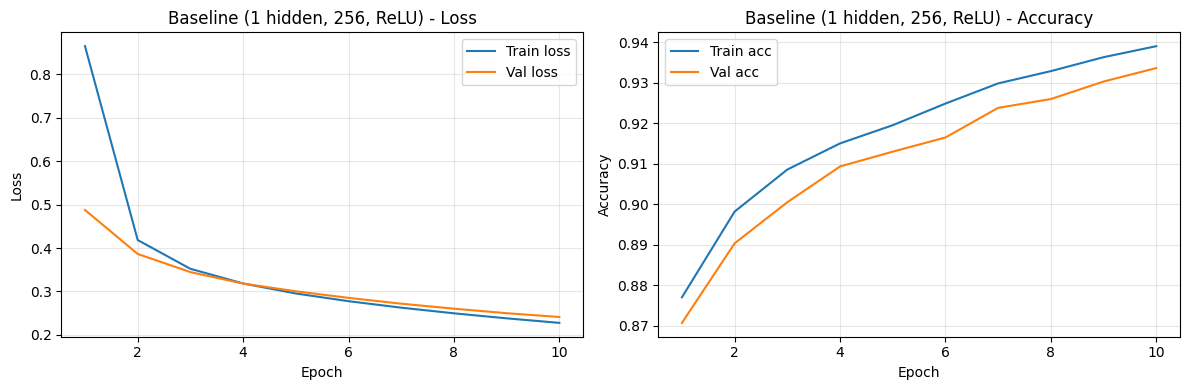

Test accuracy (baseline): 0.9377


In [9]:
# Baseline: [784, 256, 10], ReLU, 10 epochs, lr=0.01
np.random.seed(42)
model_baseline = NeuralNetwork(layer_sizes=[784, 256, 10], activation='relu')
history_baseline = train_model(model_baseline, X_train, y_train_oh, X_val, y_val_oh, epochs=10, lr=0.01, batch_size=64)
plot_history(history_baseline, 'Baseline (1 hidden, 256, ReLU)', save_path='experiment_results/baseline.png')
test_acc_baseline = model_baseline.evaluate(X_test, y_test_oh)
print("Test accuracy (baseline):", test_acc_baseline)

## 5. Experiments

Vary:
- **Number of hidden layers** (1, 2, 3)
- **Number of neurons per layer** (128, 256, 512)
- **Activation functions** (ReLU, Sigmoid, Tanh)

Results (tables and plots) are saved under `experiment_results/`.

In [10]:
# Experiment configs: (name, layer_sizes, activation)
# layer_sizes: [784, ..., 10]; we vary hidden layers and widths
experiment_configs = [
    # Number of hidden layers
    ("exp_1hl_256_relu", [784, 256, 10], "relu"),
    ("exp_2hl_256_relu", [784, 256, 256, 10], "relu"),
    ("exp_3hl_256_relu", [784, 256, 256, 256, 10], "relu"),
    # Neurons per layer
    ("exp_1hl_128_relu", [784, 128, 10], "relu"),
    ("exp_1hl_512_relu", [784, 512, 10], "relu"),
    # Activation functions (1 hidden, 256)
    ("exp_1hl_256_sigmoid", [784, 256, 10], "sigmoid"),
    ("exp_1hl_256_tanh", [784, 256, 10], "tanh"),
]

EPOCHS = 15
LR = 0.01
BATCH_SIZE = 64

Epoch 1/15  train_loss=0.8646  train_acc=0.8770  val_loss=0.4876  val_acc=0.8707
Epoch 2/15  train_loss=0.4183  train_acc=0.8982  val_loss=0.3863  val_acc=0.8903
Epoch 3/15  train_loss=0.3521  train_acc=0.9086  val_loss=0.3445  val_acc=0.9005
Epoch 4/15  train_loss=0.3183  train_acc=0.9150  val_loss=0.3182  val_acc=0.9093
Epoch 5/15  train_loss=0.2953  train_acc=0.9195  val_loss=0.3004  val_acc=0.9130
Epoch 6/15  train_loss=0.2776  train_acc=0.9249  val_loss=0.2853  val_acc=0.9165
Epoch 7/15  train_loss=0.2627  train_acc=0.9299  val_loss=0.2718  val_acc=0.9238
Epoch 8/15  train_loss=0.2497  train_acc=0.9329  val_loss=0.2604  val_acc=0.9260
Epoch 9/15  train_loss=0.2381  train_acc=0.9364  val_loss=0.2499  val_acc=0.9303
Epoch 10/15  train_loss=0.2276  train_acc=0.9391  val_loss=0.2412  val_acc=0.9337
Epoch 11/15  train_loss=0.2185  train_acc=0.9406  val_loss=0.2339  val_acc=0.9353
Epoch 12/15  train_loss=0.2099  train_acc=0.9440  val_loss=0.2248  val_acc=0.9368
Epoch 13/15  train_loss=0

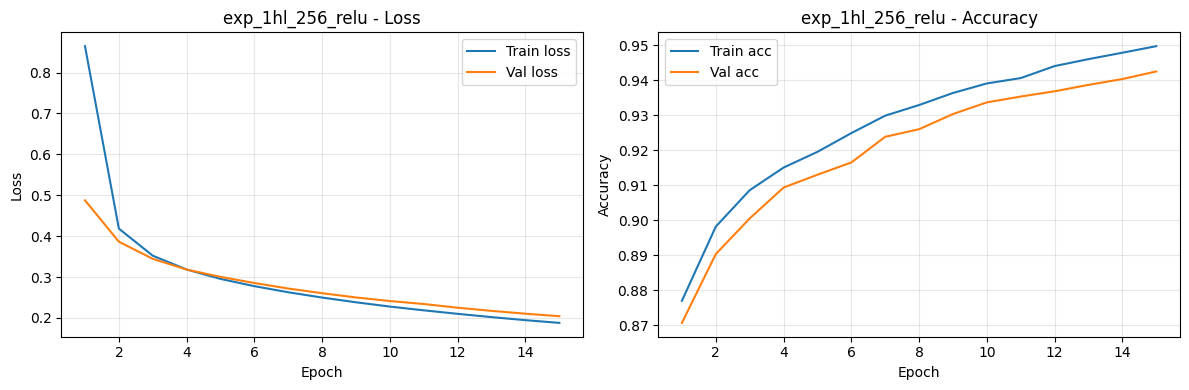

Test accuracy (exp_1hl_256_relu): 0.9464

Epoch 1/15  train_loss=0.7684  train_acc=0.8952  val_loss=0.3994  val_acc=0.8908
Epoch 2/15  train_loss=0.3359  train_acc=0.9152  val_loss=0.3177  val_acc=0.9098
Epoch 3/15  train_loss=0.2797  train_acc=0.9279  val_loss=0.2782  val_acc=0.9200
Epoch 4/15  train_loss=0.2471  train_acc=0.9347  val_loss=0.2533  val_acc=0.9253
Epoch 5/15  train_loss=0.2232  train_acc=0.9398  val_loss=0.2368  val_acc=0.9312
Epoch 6/15  train_loss=0.2045  train_acc=0.9444  val_loss=0.2195  val_acc=0.9360
Epoch 7/15  train_loss=0.1887  train_acc=0.9495  val_loss=0.2013  val_acc=0.9422
Epoch 8/15  train_loss=0.1756  train_acc=0.9526  val_loss=0.1922  val_acc=0.9443
Epoch 9/15  train_loss=0.1642  train_acc=0.9557  val_loss=0.1781  val_acc=0.9460
Epoch 10/15  train_loss=0.1540  train_acc=0.9583  val_loss=0.1715  val_acc=0.9485
Epoch 11/15  train_loss=0.1451  train_acc=0.9607  val_loss=0.1643  val_acc=0.9520
Epoch 12/15  train_loss=0.1370  train_acc=0.9632  val_loss=0.1575

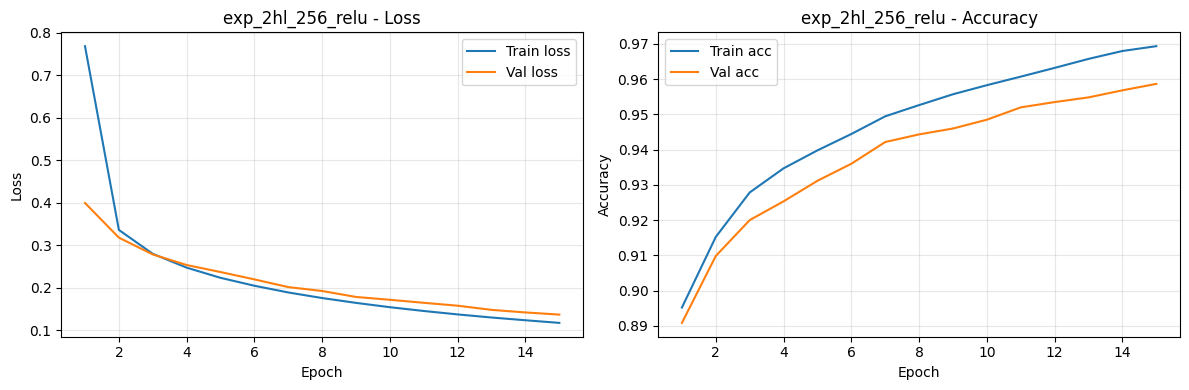

Test accuracy (exp_2hl_256_relu): 0.9628

Epoch 1/15  train_loss=0.6847  train_acc=0.9013  val_loss=0.3583  val_acc=0.8937
Epoch 2/15  train_loss=0.3011  train_acc=0.9248  val_loss=0.2830  val_acc=0.9180
Epoch 3/15  train_loss=0.2465  train_acc=0.9364  val_loss=0.2422  val_acc=0.9292
Epoch 4/15  train_loss=0.2123  train_acc=0.9434  val_loss=0.2175  val_acc=0.9348
Epoch 5/15  train_loss=0.1879  train_acc=0.9491  val_loss=0.1981  val_acc=0.9413
Epoch 6/15  train_loss=0.1677  train_acc=0.9547  val_loss=0.1840  val_acc=0.9452
Epoch 7/15  train_loss=0.1512  train_acc=0.9595  val_loss=0.1658  val_acc=0.9487
Epoch 8/15  train_loss=0.1370  train_acc=0.9632  val_loss=0.1513  val_acc=0.9533
Epoch 9/15  train_loss=0.1254  train_acc=0.9674  val_loss=0.1413  val_acc=0.9563
Epoch 10/15  train_loss=0.1151  train_acc=0.9695  val_loss=0.1347  val_acc=0.9617
Epoch 11/15  train_loss=0.1066  train_acc=0.9732  val_loss=0.1289  val_acc=0.9630
Epoch 12/15  train_loss=0.0990  train_acc=0.9750  val_loss=0.1216

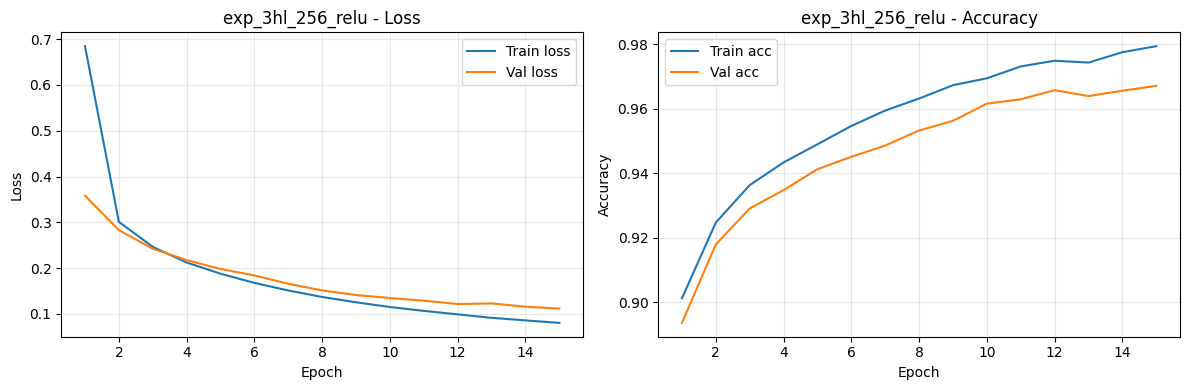

Test accuracy (exp_3hl_256_relu): 0.9689

Epoch 1/15  train_loss=0.9268  train_acc=0.8735  val_loss=0.5074  val_acc=0.8678
Epoch 2/15  train_loss=0.4332  train_acc=0.8944  val_loss=0.3960  val_acc=0.8873
Epoch 3/15  train_loss=0.3620  train_acc=0.9045  val_loss=0.3536  val_acc=0.8988
Epoch 4/15  train_loss=0.3271  train_acc=0.9124  val_loss=0.3275  val_acc=0.9073
Epoch 5/15  train_loss=0.3037  train_acc=0.9179  val_loss=0.3084  val_acc=0.9127
Epoch 6/15  train_loss=0.2860  train_acc=0.9221  val_loss=0.2927  val_acc=0.9165
Epoch 7/15  train_loss=0.2714  train_acc=0.9259  val_loss=0.2808  val_acc=0.9202
Epoch 8/15  train_loss=0.2588  train_acc=0.9299  val_loss=0.2707  val_acc=0.9228
Epoch 9/15  train_loss=0.2480  train_acc=0.9334  val_loss=0.2595  val_acc=0.9263
Epoch 10/15  train_loss=0.2382  train_acc=0.9350  val_loss=0.2505  val_acc=0.9305
Epoch 11/15  train_loss=0.2290  train_acc=0.9372  val_loss=0.2437  val_acc=0.9323
Epoch 12/15  train_loss=0.2208  train_acc=0.9401  val_loss=0.2337

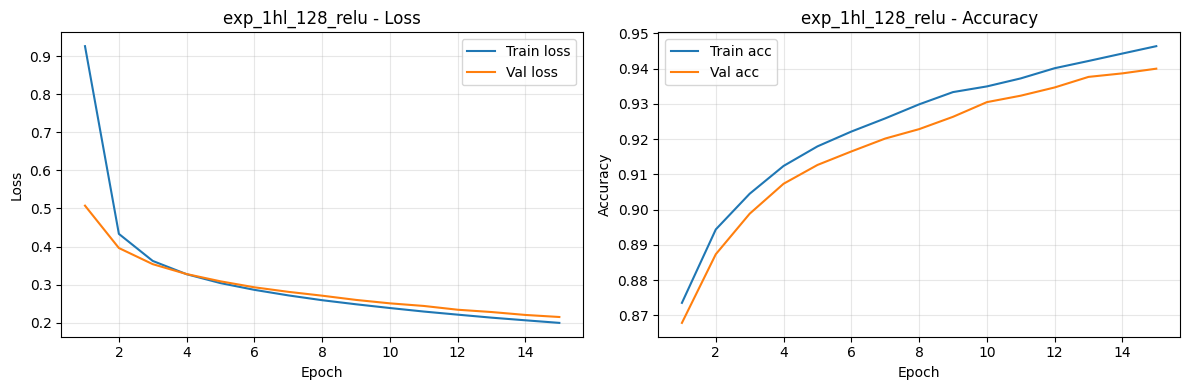

Test accuracy (exp_1hl_128_relu): 0.9443

Epoch 1/15  train_loss=0.8169  train_acc=0.8799  val_loss=0.4747  val_acc=0.8765
Epoch 2/15  train_loss=0.4057  train_acc=0.9006  val_loss=0.3786  val_acc=0.8952
Epoch 3/15  train_loss=0.3419  train_acc=0.9094  val_loss=0.3369  val_acc=0.9038
Epoch 4/15  train_loss=0.3089  train_acc=0.9177  val_loss=0.3112  val_acc=0.9123
Epoch 5/15  train_loss=0.2864  train_acc=0.9234  val_loss=0.2913  val_acc=0.9180
Epoch 6/15  train_loss=0.2686  train_acc=0.9276  val_loss=0.2762  val_acc=0.9232
Epoch 7/15  train_loss=0.2540  train_acc=0.9323  val_loss=0.2638  val_acc=0.9263
Epoch 8/15  train_loss=0.2415  train_acc=0.9347  val_loss=0.2533  val_acc=0.9297
Epoch 9/15  train_loss=0.2304  train_acc=0.9386  val_loss=0.2409  val_acc=0.9342
Epoch 10/15  train_loss=0.2205  train_acc=0.9403  val_loss=0.2333  val_acc=0.9350
Epoch 11/15  train_loss=0.2114  train_acc=0.9436  val_loss=0.2245  val_acc=0.9387
Epoch 12/15  train_loss=0.2034  train_acc=0.9454  val_loss=0.2185

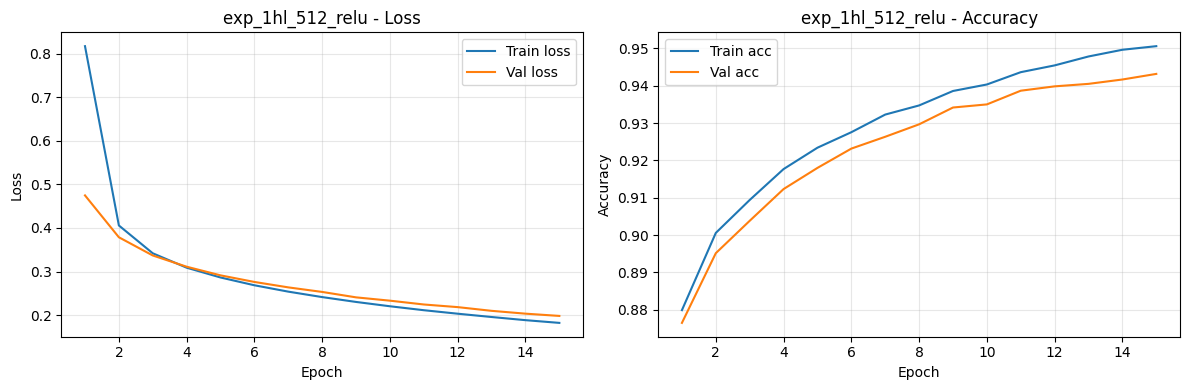

Test accuracy (exp_1hl_512_relu): 0.9499

Epoch 1/15  train_loss=1.9319  train_acc=0.7237  val_loss=1.5504  val_acc=0.7293
Epoch 2/15  train_loss=1.2549  train_acc=0.8096  val_loss=1.0150  val_acc=0.8112
Epoch 3/15  train_loss=0.8759  train_acc=0.8374  val_loss=0.7648  val_acc=0.8373
Epoch 4/15  train_loss=0.6941  train_acc=0.8559  val_loss=0.6386  val_acc=0.8582
Epoch 5/15  train_loss=0.5940  train_acc=0.8641  val_loss=0.5632  val_acc=0.8647
Epoch 6/15  train_loss=0.5311  train_acc=0.8740  val_loss=0.5137  val_acc=0.8743
Epoch 7/15  train_loss=0.4881  train_acc=0.8802  val_loss=0.4786  val_acc=0.8770
Epoch 8/15  train_loss=0.4570  train_acc=0.8842  val_loss=0.4527  val_acc=0.8820
Epoch 9/15  train_loss=0.4335  train_acc=0.8881  val_loss=0.4331  val_acc=0.8833
Epoch 10/15  train_loss=0.4148  train_acc=0.8901  val_loss=0.4178  val_acc=0.8847
Epoch 11/15  train_loss=0.4003  train_acc=0.8932  val_loss=0.4042  val_acc=0.8882
Epoch 12/15  train_loss=0.3881  train_acc=0.8956  val_loss=0.3938

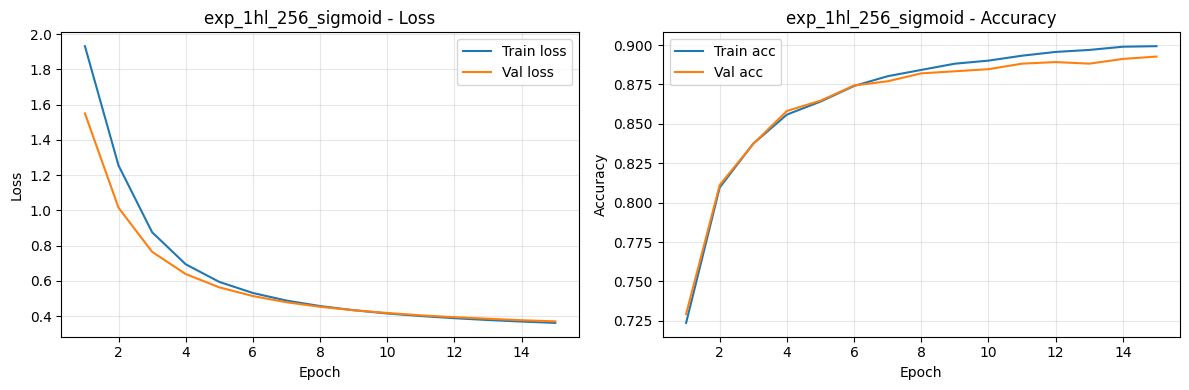

Test accuracy (exp_1hl_256_sigmoid): 0.9040

Epoch 1/15  train_loss=0.8953  train_acc=0.8699  val_loss=0.5287  val_acc=0.8663
Epoch 2/15  train_loss=0.4560  train_acc=0.8891  val_loss=0.4196  val_acc=0.8820
Epoch 3/15  train_loss=0.3863  train_acc=0.8985  val_loss=0.3788  val_acc=0.8915
Epoch 4/15  train_loss=0.3540  train_acc=0.9042  val_loss=0.3550  val_acc=0.8975
Epoch 5/15  train_loss=0.3341  train_acc=0.9077  val_loss=0.3409  val_acc=0.8988
Epoch 6/15  train_loss=0.3200  train_acc=0.9108  val_loss=0.3296  val_acc=0.9030
Epoch 7/15  train_loss=0.3089  train_acc=0.9145  val_loss=0.3201  val_acc=0.9078
Epoch 8/15  train_loss=0.2997  train_acc=0.9164  val_loss=0.3125  val_acc=0.9097
Epoch 9/15  train_loss=0.2919  train_acc=0.9191  val_loss=0.3055  val_acc=0.9125
Epoch 10/15  train_loss=0.2847  train_acc=0.9211  val_loss=0.2996  val_acc=0.9132
Epoch 11/15  train_loss=0.2784  train_acc=0.9228  val_loss=0.2942  val_acc=0.9153
Epoch 12/15  train_loss=0.2723  train_acc=0.9242  val_loss=0.2

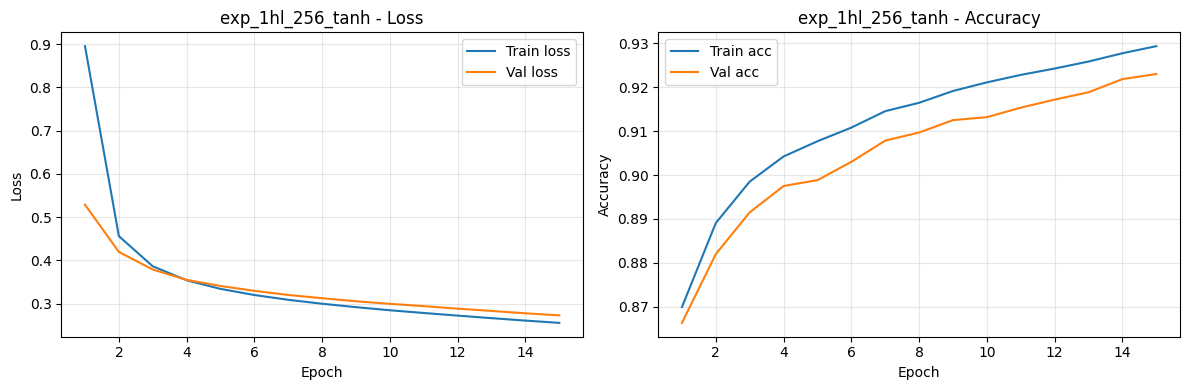

Test accuracy (exp_1hl_256_tanh): 0.9299



In [11]:
# Run all experiments and collect results
results = []
for name, layer_sizes, activation in experiment_configs:
    np.random.seed(42)
    model = NeuralNetwork(layer_sizes=layer_sizes, activation=activation)
    history = train_model(model, X_train, y_train_oh, X_val, y_val_oh,
                          epochs=EPOCHS, lr=LR, batch_size=BATCH_SIZE, verbose=True)
    final_train_loss = history['train_loss'][-1]
    final_train_acc = history['train_acc'][-1]
    final_val_loss = history['val_loss'][-1]
    final_val_acc = history['val_acc'][-1]
    test_acc = model.evaluate(X_test, y_test_oh)
    results.append({
        'name': name,
        'layers': len(layer_sizes) - 2,  # hidden layer count
        'neurons': layer_sizes[1] if len(layer_sizes) > 2 else 0,
        'activation': activation,
        'train_loss': final_train_loss,
        'train_acc': final_train_acc,
        'val_loss': final_val_loss,
        'val_acc': final_val_acc,
        'test_acc': test_acc,
        'history': history,
    })
    plot_history(history, name, save_path=f'experiment_results/{name}.png')
    print(f"Test accuracy ({name}): {test_acc:.4f}\n")

In [ ]:
# Build results table and save
df = pd.DataFrame([{
    'Experiment': r['name'],
    'Hidden layers': r['layers'],
    'Neurons/layer': r['neurons'],
    'Activation': r['activation'],
    'Train loss': round(r['train_loss'], 4),
    'Train acc': round(r['train_acc'], 4),
    'Val loss': round(r['val_loss'], 4),
    'Val acc': round(r['val_acc'], 4),
    'Test acc': round(r['test_acc'], 4),
} for r in results])
print("Experiment results:")
display(df)
df.to_csv('experiment_results/experiment_results_table.csv', index=False)
print("\nTable saved to experiment_results/experiment_results_table.csv")

Experiment results:


,Experiment,Hidden layers,Neurons/layer,Activation,Train loss,Train acc,Val loss,Val acc,Test acc
0,exp_1hl_256_relu,1,256,relu,0.1878,0.9497,0.2041,0.9425,0.9464
1,exp_2hl_256_relu,2,256,relu,0.1171,0.9694,0.1366,0.9587,0.9628
2,exp_3hl_256_relu,3,256,relu,0.0804,0.9795,0.1117,0.9672,0.9689
3,exp_1hl_128_relu,1,128,relu,0.1991,0.9464,0.2146,0.9400,0.9443
4,exp_1hl_512_relu,1,512,relu,0.1823,0.9506,0.1983,0.9432,0.9499
5,exp_1hl_256_sigmoid,1,256,sigmoid,0.3615,0.8993,0.3702,0.8927,0.9040
6,exp_1hl_256_tanh,1,256,tanh,0.2555,0.9293,0.2729,0.9230,0.9299



Table saved to experiment_results/experiment_results_table.csv


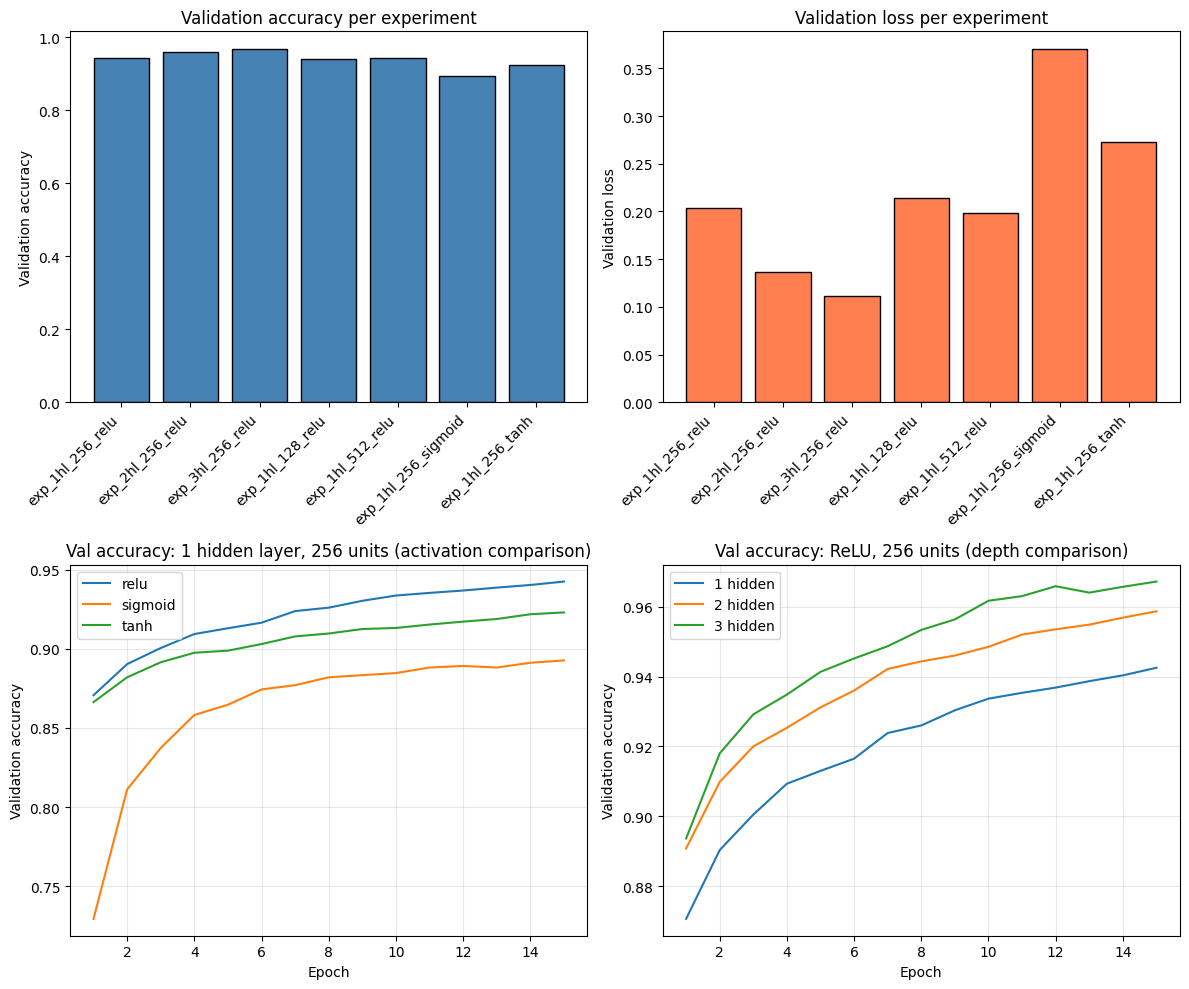

Summary plot saved to experiment_results/summary_comparison.png


In [13]:
# Summary plots: compare experiments
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Val accuracy by experiment
ax = axes[0, 0]
ax.bar(range(len(results)), [r['val_acc'] for r in results], color='steelblue', edgecolor='black')
ax.set_xticks(range(len(results)))
ax.set_xticklabels([r['name'] for r in results], rotation=45, ha='right')
ax.set_ylabel('Validation accuracy')
ax.set_title('Validation accuracy per experiment')

# Val loss by experiment
ax = axes[0, 1]
ax.bar(range(len(results)), [r['val_loss'] for r in results], color='coral', edgecolor='black')
ax.set_xticks(range(len(results)))
ax.set_xticklabels([r['name'] for r in results], rotation=45, ha='right')
ax.set_ylabel('Validation loss')
ax.set_title('Validation loss per experiment')

# Learning curves: val accuracy over epochs for a subset (e.g. activations)
ax = axes[1, 0]
for r in results:
    if '1hl_256' in r['name']:
        ax.plot(range(1, EPOCHS+1), r['history']['val_acc'], label=r['activation'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation accuracy')
ax.set_title('Val accuracy: 1 hidden layer, 256 units (activation comparison)')
ax.legend()
ax.grid(True, alpha=0.3)

# Learning curves: hidden layers (ReLU, 256)
ax = axes[1, 1]
for r in results:
    if 'relu' in r['name'] and '256' in r['name'] and 'hl' in r['name']:
        ax.plot(range(1, EPOCHS+1), r['history']['val_acc'], label=f"{r['layers']} hidden")
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation accuracy')
ax.set_title('Val accuracy: ReLU, 256 units (depth comparison)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_results/summary_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Summary plot saved to experiment_results/summary_comparison.png")